# Inferring ages from velocity dispersions.

I want to build a hierarchical model, where I infer the velocity dispersion (root-variance) of the velocities, vz, by deconvolving the transformation between vb and vz. The variance on each velocity, vb, is artificially increased as a function of b: $\sigma = 0.44 b + 0.15$

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [145]:
np.random.seed(42)
N = 1000

beta = .52
m, c = .44, .15
b = np.random.uniform(5, 15, N)

age = 9
t = np.ones(N)*age
vz = np.random.randn(N)*(age**beta)
vb = vz + np.random.randn(N)*(m*b + c)

Text(0.5, 0, 'Velocity')

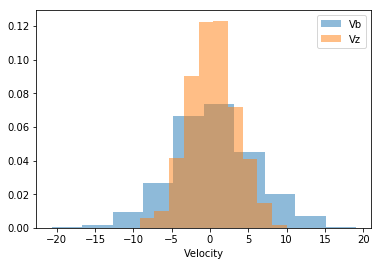

In [146]:
plt.hist(vb, density=True, alpha=.5, label="Vb");
plt.hist(vz, density=True, alpha=.5, label="Vz");
plt.legend()
plt.xlabel("Velocity")

Task: try to recover the age that was used to generate these velocities (5 Gyr).

$$\sigma_v = t^\beta$$
$$t = \sigma_v^{1/\beta}$$

In [147]:
vb_age = np.std(vb)**(1./beta)
vz_age = np.std(vz)**(1./beta)
print(vb_age, vz_age)

26.041406239907126 8.800964193982916


Build a hierarchical model, marginalizing over vz for each star, in order to infer mu and sigma of the true Gaussian.

In [148]:
import pymc3 as pm

simple_model = pm.Model()

with simple_model:
    
    # Prior over mu
    mu = pm.Uniform("mu", lower=-100, upper=100)
    # Prior over sigma
    sigma = pm.Uniform("sigma", lower=0, upper=100)
    
    # vz
    vz_hat = pm.Normal("vz_hat", mu=mu, sigma=sigma, shape=N)
    
    # vb (the likelihood)
    vb_hat = pm.Normal("vb_hat", mu=vz_hat, sigma=(m*b + c), observed=vb)

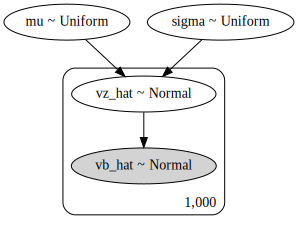

In [149]:
pm.model_to_graphviz(simple_model)

In [150]:
with simple_model:
    trace = pm.sample(tune=5000, draws=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vz_hat, sigma, mu]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:40<00:00, 980.32draws/s] 
The number of effective samples is smaller than 10% for some parameters.


In [151]:
print(np.median(trace.mu), np.median(trace.sigma))

0.3801257045317499 2.8668494184323032


In [152]:
print("age = ", np.median(trace.sigma)**(1./beta))

age =  7.579224537960121


In [133]:
truth = [1, 2, 3, 4, 5, 6, 7, 8, 9]
inferred = [2.0555103744973375, 3.2833328940327706, 4.08944715141667, 5.457687396440361,
            6.139655961051819, 7.426902050389883, 8.252891456901786, 9.38125783234722,
            10.384444408936119]

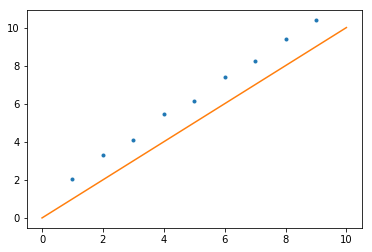

In [134]:
plt.plot(truth, inferred, ".")
xs = np.linspace(0, 10, 100)
plt.plot(xs, xs)

In [156]:
ages, err, errp, errm = [], [], [], []

for age in range(1, 10):
    
    # Generate data
    print("testing age = ", age)
    t = np.ones(N)*age
    vz = np.random.randn(N)*(age**beta)
    vb = vz + np.random.randn(N)*(m*b + c)
    
    # Hierarchical model
    simple_model = pm.Model()
    with simple_model:
        # Prior over mu
        mu = pm.Uniform("mu", lower=-100, upper=100)
        # Prior over sigma
        sigma = pm.Uniform("sigma", lower=0, upper=100)
        # vz
        vz_hat = pm.Normal("vz_hat", mu=mu, sigma=sigma, shape=N) 
        # vb (the likelihood)
        vb_hat = pm.Normal("vb_hat", mu=vz_hat, sigma=(m*b + c), observed=vb)
        
    # Sample
    with simple_model:
        trace = pm.sample(tune=5000, draws=5000)
        
    age_array = trace.sigma**(1./beta)
    ages.append(np.median(age_array))
    err.append(np.std(age_array))
    upper, lower = np.percentile(age_array, 85), np.percentile(age_array, 16)
    errp.append(upper - np.median(age_array))
    errm.append(np.median(age_array) - lower)

testing age =  1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vz_hat, sigma, mu]
Sampling 4 chains: 100%|██████████| 40000/40000 [01:20<00:00, 496.53draws/s] 
There were 4746 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.10380656302443599, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4424 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.13866690930015071, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1710 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5450306221008084, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2639 divergences after tuning. Increase `target_ac

testing age =  2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vz_hat, sigma, mu]
Sampling 4 chains: 100%|██████████| 40000/40000 [01:14<00:00, 536.87draws/s] 
The number of effective samples is smaller than 10% for some parameters.


testing age =  3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vz_hat, sigma, mu]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:47<00:00, 848.83draws/s] 
The number of effective samples is smaller than 10% for some parameters.


testing age =  4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vz_hat, sigma, mu]
Sampling 4 chains: 100%|██████████| 40000/40000 [01:03<00:00, 634.14draws/s] 
The number of effective samples is smaller than 10% for some parameters.


testing age =  5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vz_hat, sigma, mu]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:40<00:00, 992.82draws/s] 
The number of effective samples is smaller than 10% for some parameters.


testing age =  6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vz_hat, sigma, mu]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:40<00:00, 991.31draws/s] 
The number of effective samples is smaller than 10% for some parameters.


testing age =  7


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vz_hat, sigma, mu]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:41<00:00, 959.56draws/s] 
The number of effective samples is smaller than 10% for some parameters.


testing age =  8


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vz_hat, sigma, mu]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:49<00:00, 812.93draws/s] 
The number of effective samples is smaller than 25% for some parameters.


testing age =  9


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vz_hat, sigma, mu]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:42<00:00, 940.05draws/s] 
The number of effective samples is smaller than 10% for some parameters.


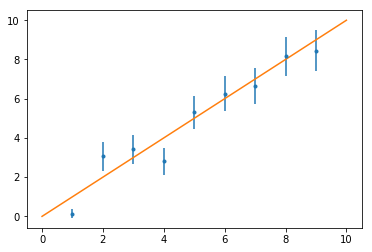

In [157]:
plt.errorbar(range(1, 10), ages, yerr=err, fmt=".")
plt.plot(xs, xs)